In [192]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
%matplotlib inline

In [107]:
def is_non_zero_file(fpath):  
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0
def prepare_log_dt(model_names):
    final_log = []
    for model in model_names:
        for fold_idx in range(5):
            file_path = os.path.join(wd,'{}.fold{}.logger.tsv'.format(model,fold_idx))
            if is_non_zero_file(file_path):
                log_dt = pd.read_csv(file_path,sep='\t')
                dt = pd.concat([pd.DataFrame({'loss':log_dt['loss'],'epoch':log_dt['epoch'],'phase':'train','model':model,'fold':fold_idx}),
                       pd.DataFrame({'loss':log_dt['val_loss'],'epoch':log_dt['epoch'],'phase':'val','model':model,'fold':fold_idx})])    
                final_log.append(dt)
    final_log = pd.concat(final_log)
    return(final_log)

### Histopathologic Cancer Detection  
#### Identify metastatic tissue in histopathologic scans of lymph node section  
This is a playground kaggle competition. The task was to design an algorythm for to identify metastatic cancer in small image patches. This was a binary classification task with a balanced class distribution, small images, fair amount of data. The metric was roc auc, so the output was our probability of cancer detection in a given image.

Load some examples for differens slides

In [146]:
patch_dt = pd.read_csv('patch_id_wsi.csv')
train_data = pd.read_csv('train_labels.csv')
train_data = pd.merge(train_data, patch_dt, on='id')

In [147]:
train_data.head()

,id,label,wsi
0,f38a6374c348f90b587e046aac6079959adf3835,0,camelyon16_train_normal_033
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,camelyon16_train_tumor_054
2,755db6279dae599ebb4d39a9123cce439965282d,0,camelyon16_train_tumor_008
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,camelyon16_train_tumor_077
4,acfe80838488fae3c89bd21ade75be5c34e66be7,0,camelyon16_train_tumor_036


Text(0.5, 1.0, 'classes distribution')

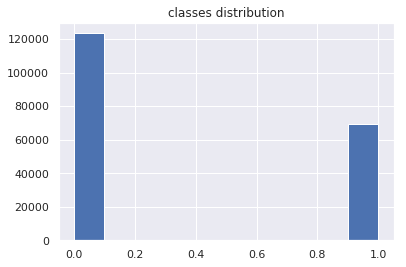

In [198]:
ax = train_data['label'].hist();
ax.set_title('classes distribution')
ax.set_ylabel('')

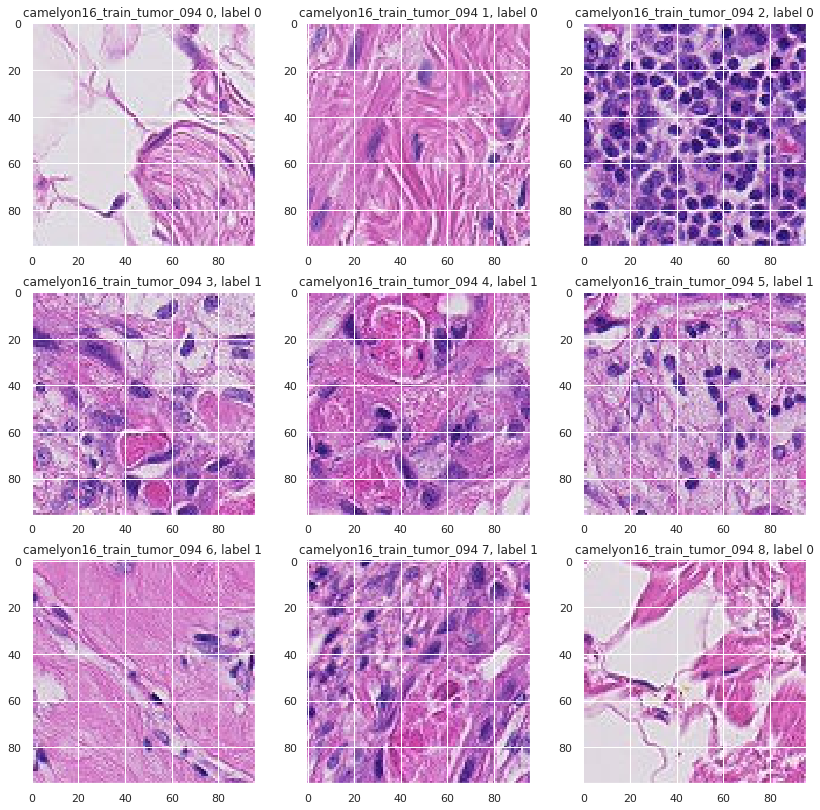

In [189]:
f, ax = plt.subplots(3,3, figsize = (14,14))
patch_sample = train_data.loc[train_data['wsi']=='camelyon16_train_tumor_094', ['id','label']].sample(n=9)
for idx in range(9):
    image = imread('/scratch/skolchen/cancer/train/{}.tif'.format(patch_sample['id'].values[idx]))
    ax[idx // 3, idx % 3].imshow(image);
    ax[idx // 3, idx % 3].set_title('camelyon16_train_tumor_094 {}, label {}'.format(idx, patch_sample['label'].values[idx]))

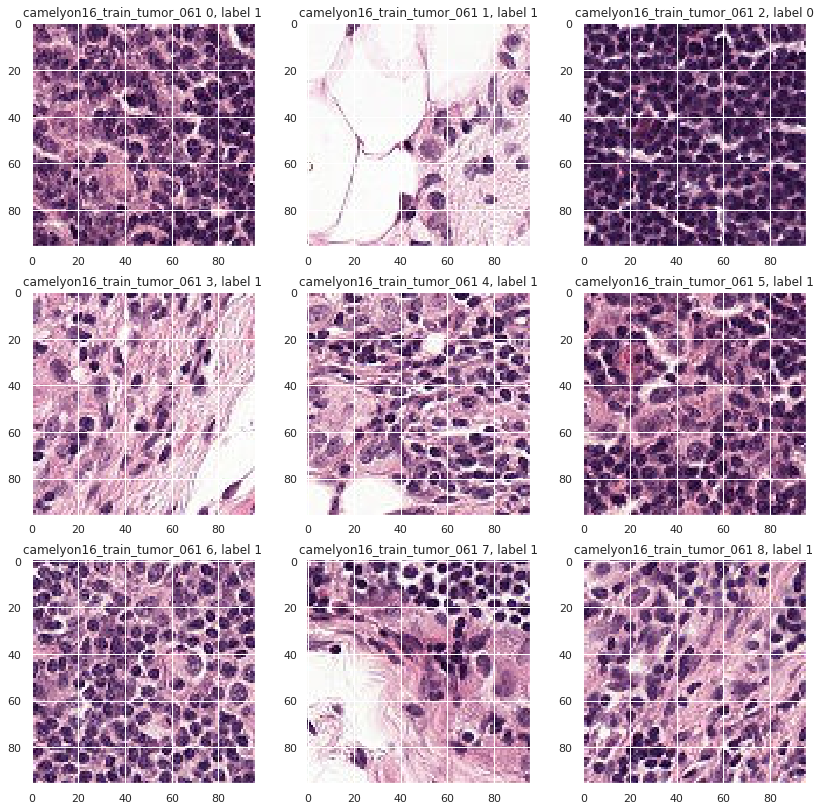

In [185]:
f, ax = plt.subplots(3,3, figsize = (14,14))
patch_sample = train_data.loc[train_data['wsi']=='camelyon16_train_tumor_061', ['id','label']].sample(n=9)
for idx in range(9):
    image = imread('/scratch/skolchen/cancer/train/{}.tif'.format(patch_sample['id'].values[idx]))
    ax[idx // 3, idx % 3].imshow(image);
    ax[idx // 3, idx % 3].set_title('camelyon16_train_tumor_061 {}, label {}'.format(idx, patch_sample['label'].values[idx]))

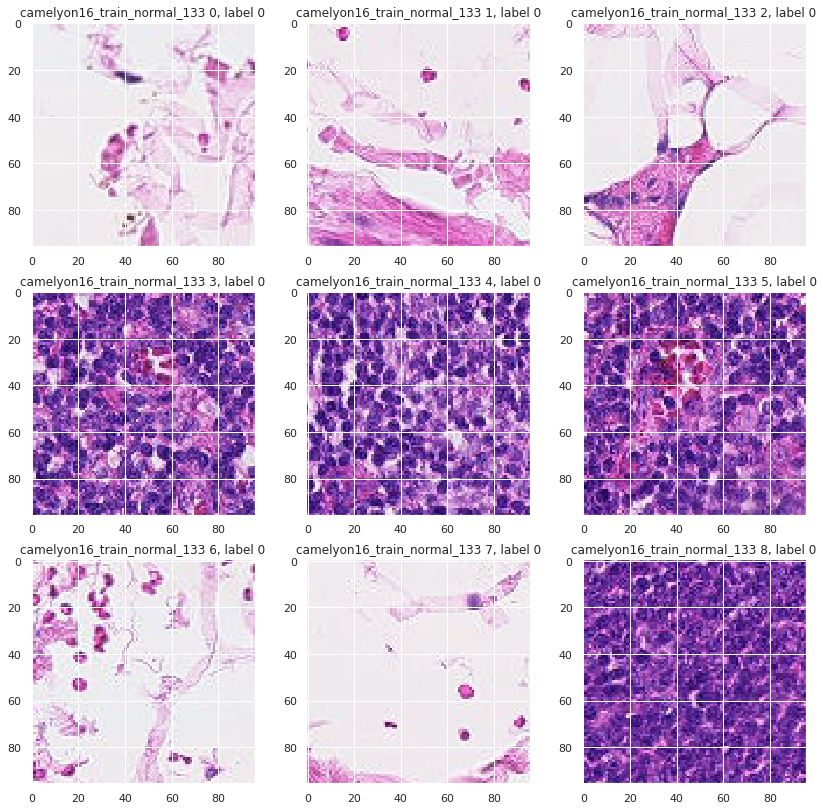

In [187]:
f, ax = plt.subplots(3,3, figsize = (14,14))
patch_sample = train_data.loc[train_data['wsi']=='camelyon16_train_normal_133', ['id','label']].sample(n=9)
for idx in range(9):
    image = imread('/scratch/skolchen/cancer/train/{}.tif'.format(patch_sample['id'].values[idx]))
    ax[idx // 3, idx % 3].imshow(image);
    ax[idx // 3, idx % 3].set_title('camelyon16_train_normal_133 {}, label {}'.format(idx, patch_sample['label'].values[idx]))

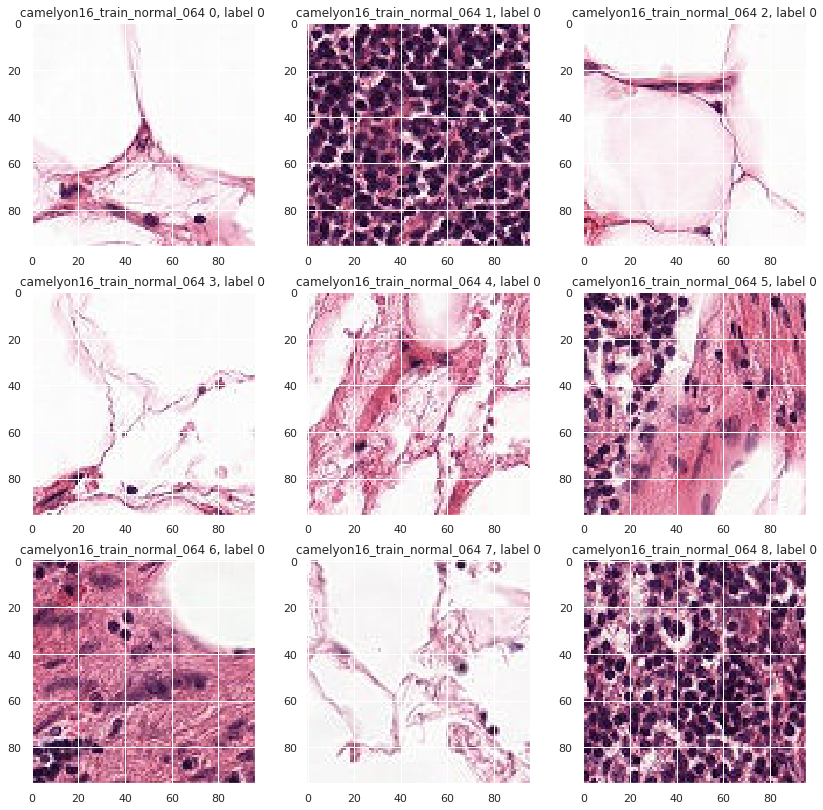

In [190]:
f, ax = plt.subplots(3,3, figsize = (14,14))
patch_sample = train_data.loc[train_data['wsi']=='camelyon16_train_normal_064', ['id','label']].sample(n=9)
for idx in range(9):
    image = imread('/scratch/skolchen/cancer/train/{}.tif'.format(patch_sample['id'].values[idx]))
    ax[idx // 3, idx % 3].imshow(image);
    ax[idx // 3, idx % 3].set_title('camelyon16_train_normal_064 {}, label {}'.format(idx, patch_sample['label'].values[idx]))

For this task I tried different models and different training schemes, the first attempt was to just train different models using same number of epochs\lr. All models were pretrained on imagenet, the classification head was replaced with one neuron layer with a sigmoid activation.

Load log files of models

In [114]:
model_names = ['densenet121','densenet169','densenet201','inceptionv3','resnet101','resnet152',
               'seresnet18','seresnet34', 'seresnet50','seresnet101','seresnext50','seresnext101']
wd = 'logs'
final_log = prepare_log_dt(model_names)
final_log.loc[:, 'type'] = final_log['model'] + '_' + final_log['phase']

In [116]:
final_log.tail()

,loss,epoch,phase,model,fold,type
21,0.072136,21,val,seresnext101,4,seresnext101_val
22,0.079368,22,val,seresnext101,4,seresnext101_val
23,0.071542,23,val,seresnext101,4,seresnext101_val
24,0.072596,24,val,seresnext101,4,seresnext101_val
25,0.080686,25,val,seresnext101,4,seresnext101_val


Plot train and validation loss of different models. All models were trained using same training scheme

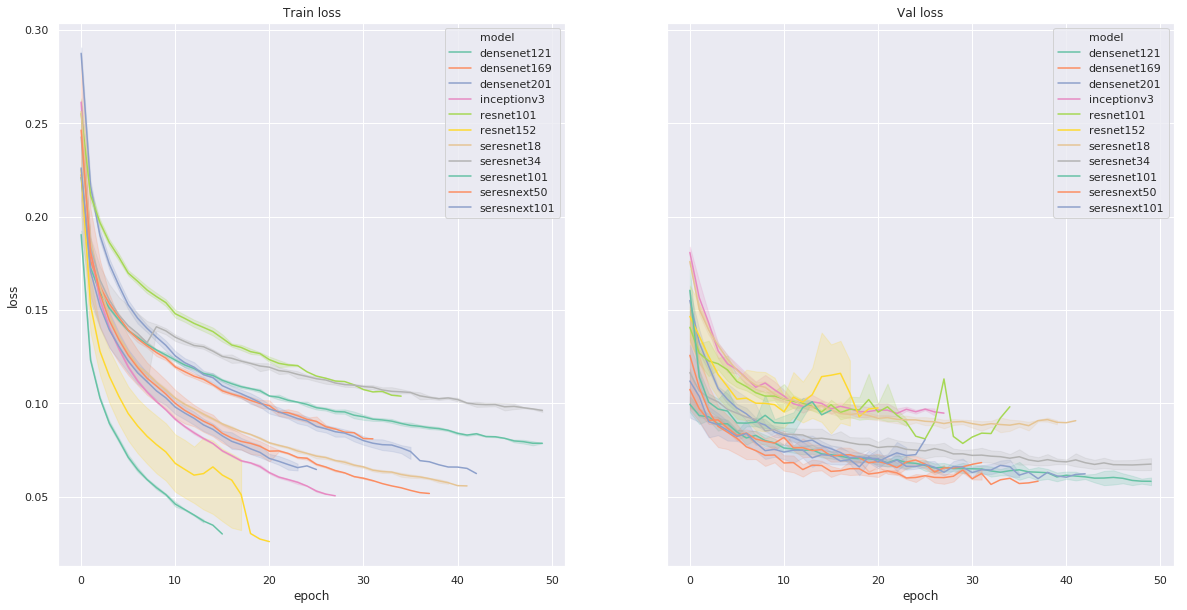

In [117]:
sns.set_context("paper")
sns.set(rc={'figure.figsize':(20,10)})
f, ax = plt.subplots(1,2,sharey=True,sharex=True)
sns.lineplot(x="epoch", y="loss", hue="model", palette=sns.color_palette("Set2", n_colors=11),
             data=final_log.loc[final_log['phase']=='train',:], ax=ax[0]).set_title('Train loss');
sns.set_context("paper")
sns.set(rc={'figure.figsize':(15,15)})
sns.lineplot(x="epoch", y="loss", hue="model", palette=sns.color_palette("Set2", n_colors=11),
             data=final_log.loc[final_log['phase']=='val',:], ax=ax[1]).set_title('Val loss');

Load table with hould out, CV, public and private LB scores. Here I have scores for models, their retrained version, with or withour tta. Addtitionaly I have several blends of independent predictions

In [123]:
results = pd.read_csv('cancer_different_models.tsv',sep='\t')
results.head()

,model,nfolds,cv auc mean,holdout auc,have oof,lb score,private lb,framework,level,process,special feature
0,SimpleMean3,5.0,0.997195,0.997632,none,0.9789,0.9795,average,2,NaN,NaN
1,SimpleMean5,5.0,0.997706,0.997020,none,0.9792,0.9794,average,2,NaN,NaN
2,SimpleMean4,NaN,NaN,NaN,none,0.9795,0.9792,average,2,NaN,NaN
3,densenet161,5.0,0.995690,0.996885,yes,0.9720,0.9781,pytorch,1,done,Adam more aug retrained tta random
4,SimpleMean,5.0,0.997690,0.998174,none,0.9774,0.9774,mean,2,done,se_resnet50.Adam.posttraining + seresnet50.Ada...


Plot correlation between different scores

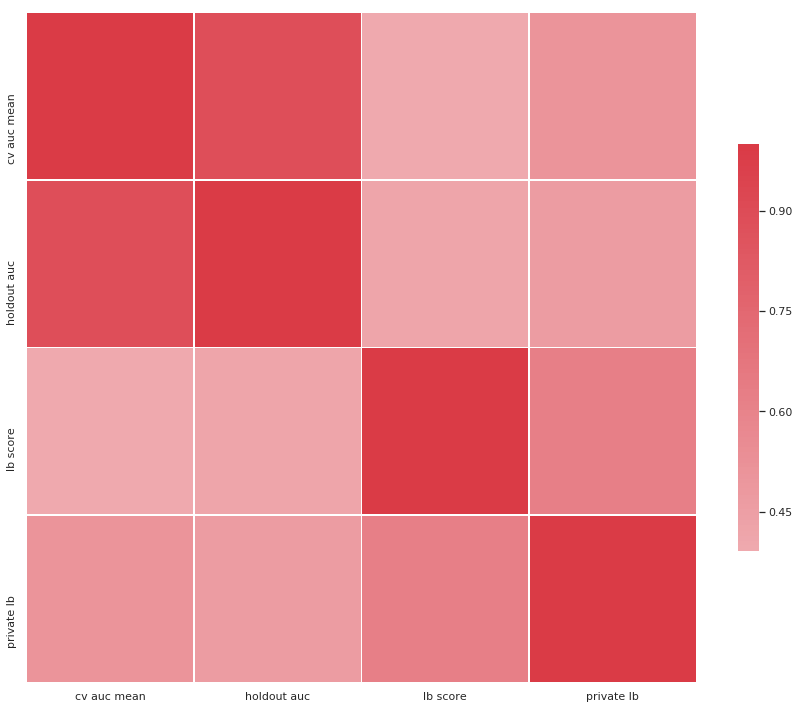

In [134]:
results_corr = results.loc[:,['cv auc mean','holdout auc','lb score','private lb']].corr()
sns.heatmap(results_corr, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Same, but with pair plots

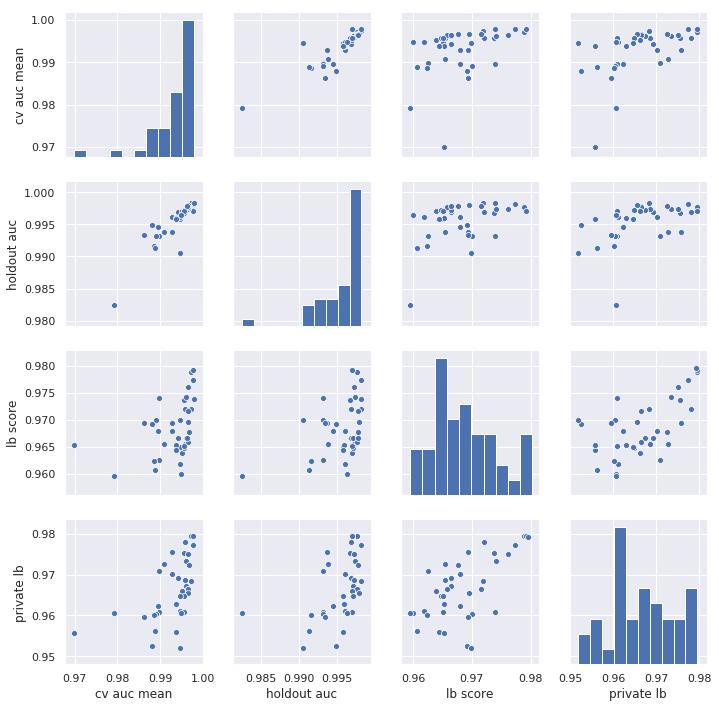

In [135]:
sns.pairplot(results.loc[:,['cv auc mean','holdout auc','lb score','private lb']]);

Let's look how correlated predictions are for different models

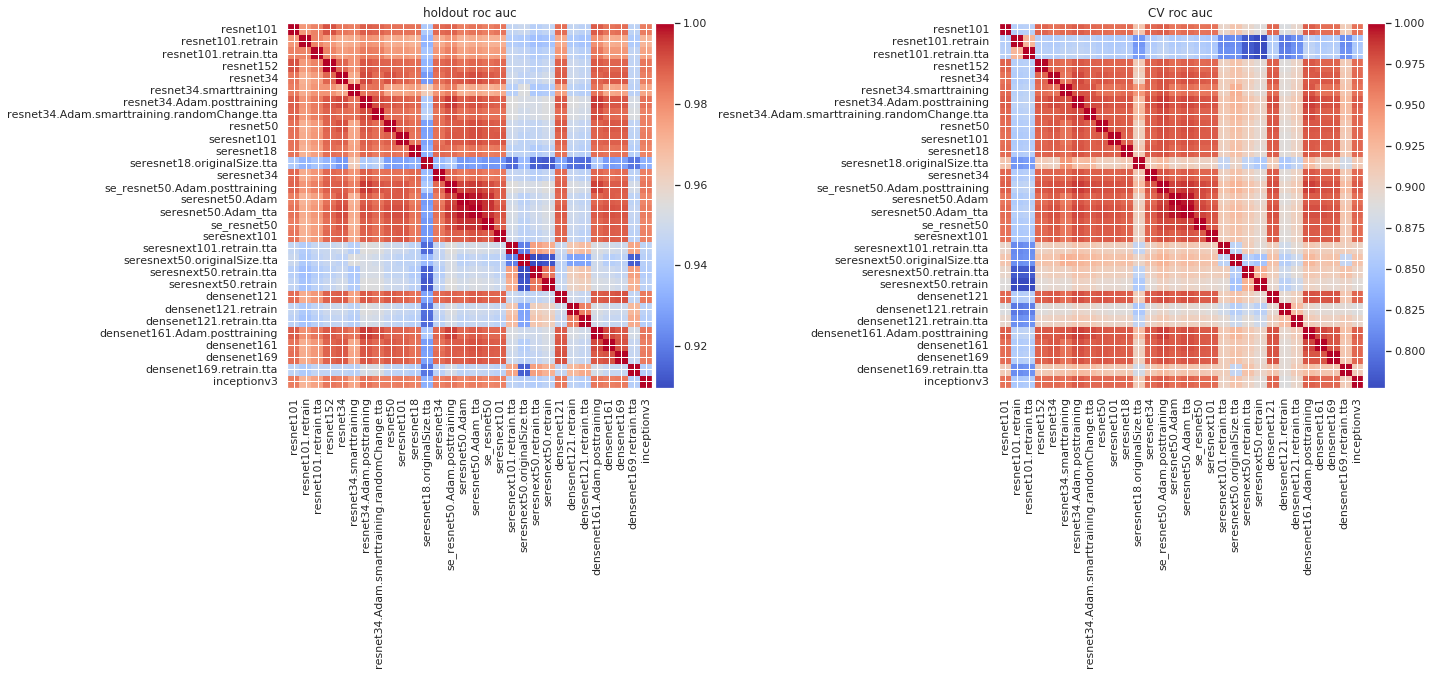

In [195]:
predictions_models = ['resnet101','resnet101.retrain','resnet101.retrain.tta',
                      'resnet152',
                      'resnet34','resnet34.smarttraining','resnet34.Adam.posttraining',
                      'resnet34.Adam.smarttraining.randomChange.tta',
                      'resnet50',
                      'seresnet101',
                      'seresnet18','seresnet18.originalSize.tta',
                      'seresnet34',
                      'se_resnet50.Adam.posttraining','seresnet50.Adam','seresnet50.Adam_tta',
                      'se_resnet50',
                      'seresnext101','seresnext101.retrain.tta',
                      'seresnext50.originalSize.tta', 'seresnext50.retrain.tta',
                      'seresnext50.retrain',
                      'densenet121','densenet121.retrain','densenet121.retrain.tta',
                      'densenet161.Adam.posttraining','densenet161','densenet169','densenet169.retrain.tta',
                      'inceptionv3']
preds = []
for model in predictions_models:
    with open(r"/scratch/skolchen/cancer/{}.Preds.pickle".format(model), "rb") as output_file:
        preds.append(pickle.load(output_file))
corr_table_oof_preds = np.corrcoef([x['oof_preds'] for x in preds])
corr_table_holdout_preds = np.corrcoef([x['holdout_preds'] for x in preds])
fig, ax = plt.subplots(1,2, figsize=(20,20))
im1 = ax[0].imshow(corr_table_holdout_preds, cmap='coolwarm')
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
ax[0].set_xticks(np.arange(len(predictions_models)))
ax[0].set_yticks(np.arange(len(predictions_models)))
ax[0].set_xticklabels(predictions_models, rotation=90)
ax[0].set_yticklabels(predictions_models)
ax[0].set_title('holdout roc auc')
im2 = ax[1].imshow(corr_table_oof_preds, cmap='coolwarm')
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
ax[1].set_xticks(np.arange(len(predictions_models)))
ax[1].set_yticks(np.arange(len(predictions_models)))
ax[1].set_xticklabels(predictions_models, rotation=90)
ax[1].set_yticklabels(predictions_models)
ax[1].set_title('CV roc auc')
plt.tight_layout()

We see that we have some models, which predictions are not higly correlated, so we can use them for blending